In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import datetime
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import seaborn as sns
from google.colab import drive

In [2]:
# Basic settings

drive.mount('/content/drive') # This step is required if your dataset is in Google Drive
data_dir = pathlib.Path('/content/drive/MyDrive/mini-dataset') # Update this path to the location of your dataset

# The optimal size for EfficientNetV2/B3 is 300x300
IMG_HEIGHT = 300
IMG_WIDTH = 300
BATCH_SIZE = 16

print(f"\nLoading dataset from '{data_dir}'...")
raw_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=None,
    shuffle=False
)

class_names = raw_ds.class_names
print("Class Names:", class_names)
print("Number of Classes:", len(class_names))

total_images = tf.data.experimental.cardinality(raw_ds).numpy()
print(f"\nTotal Number of Images: {total_images}")

raw_ds = raw_ds.shuffle(buffer_size=total_images, seed=42)

test_split_ratio = 0.15
val_split_ratio = 0.15
train_split_ratio = 1.0 - test_split_ratio - val_split_ratio

test_size_images = int(total_images * test_split_ratio)
val_size_images = int(total_images * val_split_ratio)
train_size_images = total_images - test_size_images - val_size_images

test_ds_raw = raw_ds.take(test_size_images)
remaining_ds_raw = raw_ds.skip(test_size_images)

val_ds_raw = remaining_ds_raw.take(val_size_images)
train_ds_raw = remaining_ds_raw.skip(val_size_images)

train_ds = train_ds_raw.batch(BATCH_SIZE)
val_ds = val_ds_raw.batch(BATCH_SIZE)
test_ds = test_ds_raw.batch(BATCH_SIZE)

print(f"\nNumber of Training Images: {train_size_images} (approx. %{int(train_split_ratio*100)})")
print(f"Number of Validation Images: {val_size_images} (approx. %{int(val_split_ratio*100)})")
print(f"Number of Test Images: {test_size_images} (approx. %{int(test_split_ratio*100)})")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\nDataset loading completed!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Loading dataset from '/content/drive/MyDrive/mini-dataset'...
Found 610 files belonging to 10 classes.
Class Names: ['alfa-romeo-giulia', 'audi-a6', 'bmw-3-series', 'dacia-logan', 'ford-mondeo', 'honda-civic', 'opel-astra', 'skoda-superb', 'tesla-s', 'toyota-corolla']
Number of Classes: 10

Total Number of Images: 610

Number of Training Images: 428 (approx. %70)
Number of Validation Images: 91 (approx. %15)
Number of Test Images: 91 (approx. %15)

Dataset loading completed!


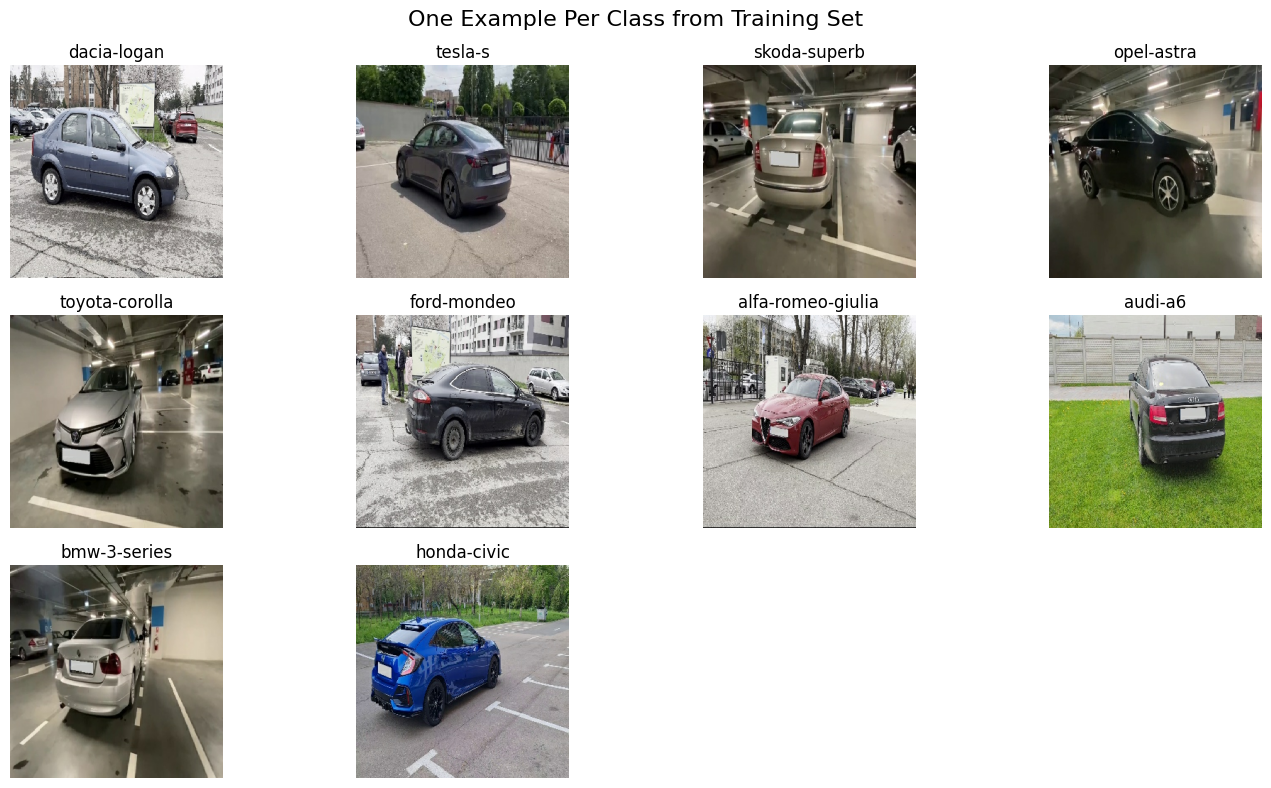

In [3]:
# Show example

shown_classes = set()
plt.figure(figsize=(14, 8))
i = 0

for images, labels in train_ds.unbatch():
    class_idx = int(labels.numpy())
    if class_idx not in shown_classes:
        ax = plt.subplot(3, (len(class_names) + 2) // 3, i + 1)
        plt.imshow(images.numpy().astype("uint8"))
        plt.title(class_names[class_idx])
        plt.axis("off")
        shown_classes.add(class_idx)
        i += 1
    if len(shown_classes) == len(class_names):
        break

plt.suptitle("One Example Per Class from Training Set", fontsize=16)
plt.tight_layout()
plt.show()

In [4]:
# Model Loading

model_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b3-feature-vector/2" # EfficientNetV2/B3 model
print(f"\nEfficientNetV2 is loading from '{model_url}'...")

feature_extractor_layer = hub.KerasLayer(
    model_url,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    trainable=True
)

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='input_image')

x = tf.keras.layers.Lambda(lambda image: feature_extractor_layer(image))(inputs) # Lambda layer workaround: Fix for an issue caused by the Hub model

x = tf.keras.layers.Dropout(0.2)(x)

num_classes = len(class_names)

outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='output_class')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()
print("\nModel loading completed!")


EfficientNetV2 is loading from 'https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b3-feature-vector/2'...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_class (Dense)            │ (None, 10)             │        15,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,370 (60.04 KB)

 Trainable params: 15,370 (60.04 KB)

 Non-trainable params: 0 (0.00 B)


Model loading completed!


In [5]:
# Training parameters

EPOCHS = 50

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print(f"\nTraining the model for {EPOCHS} epochs...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping, tensorboard_callback]
)

print("\nModel training completed!")


Training the model for 50 epochs...
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.1416 - loss: 3.6233 - val_accuracy: 0.4396 - val_loss: 1.5302
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.3911 - loss: 1.7865 - val_accuracy: 0.5934 - val_loss: 1.2187
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.5485 - loss: 1.2386 - val_accuracy: 0.7143 - val_loss: 0.9713
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.6368 - loss: 0.9959 - val_accuracy: 0.7253 - val_loss: 0.9318
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.6812 - loss: 0.8740 - val_accuracy: 0.7473 - val_loss: 0.8326
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.7754 - loss: 0.7030 - val_accuracy: 0.7582 - val_loss: 0.7449
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.7361 - loss: 0.7049 - val_accuracy: 0.8022 - val_loss: 0.6775
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.7944 - loss: 0

In [6]:
# Saving the model

model_save_path = '/content/drive/MyDrive/my_efficientnetv2_model.keras' # Do not forget to add the .keras or .h5 extension
model.save(model_save_path)
print(f"\nThe model successfully saved to '{model_save_path}'")


The model successfully saved to '/content/drive/MyDrive/my_efficientnetv2_model.keras'



Model Evaluation on the Test Dataset:
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8982 - loss: 0.3611
Test Loss: 0.4619
Test Accuracy: 0.8571


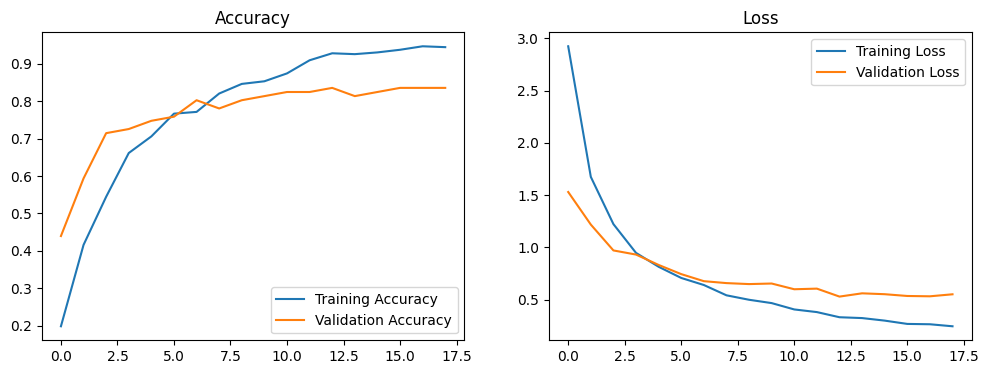

In [7]:
# Accuracy/Loss Graphs

print("\nModel Evaluation on the Test Dataset:")

loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss_vals = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_vals, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend(loc='upper right')

plt.show()

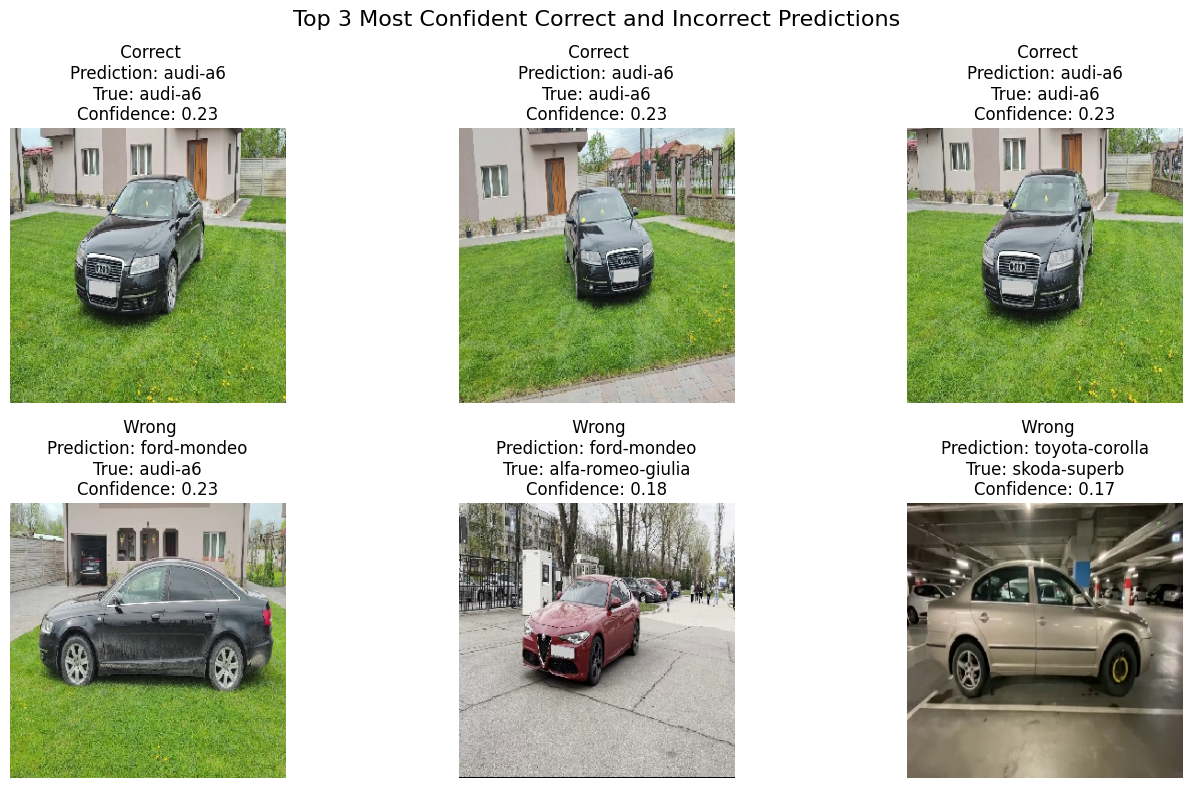

In [8]:
# Collect predictions

image_list = []
true_labels = []
predicted_labels = []
confidences = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    probs = tf.nn.softmax(predictions, axis=1).numpy()
    preds = np.argmax(probs, axis=1)

    image_list.extend(images.numpy())
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)
    confidences.extend([probs[i, pred] for i, pred in enumerate(preds)])

results = list(zip(image_list, true_labels, predicted_labels, confidences))

correct = [r for r in results if r[1] == r[2]]
incorrect = [r for r in results if r[1] != r[2]]

top_correct = sorted(correct, key=lambda x: -x[3])[:3]

top_incorrect = sorted(incorrect, key=lambda x: -x[3])[:3]

plt.figure(figsize=(14, 8))

for i, (img, true, pred, conf) in enumerate(top_correct):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f" Correct\nPrediction: {class_names[pred]}\nTrue: {class_names[true]}\nConfidence: {conf:.2f}")
    plt.axis("off")

for i, (img, true, pred, conf) in enumerate(top_incorrect):
    ax = plt.subplot(2, 3, i + 4)
    plt.imshow(img.astype("uint8"))
    plt.title(f" Wrong\nPrediction: {class_names[pred]}\nTrue: {class_names[true]}\nConfidence: {conf:.2f}")
    plt.axis("off")

plt.suptitle("Top 3 Most Confident Correct and Incorrect Predictions", fontsize=16)
plt.tight_layout()
plt.show()

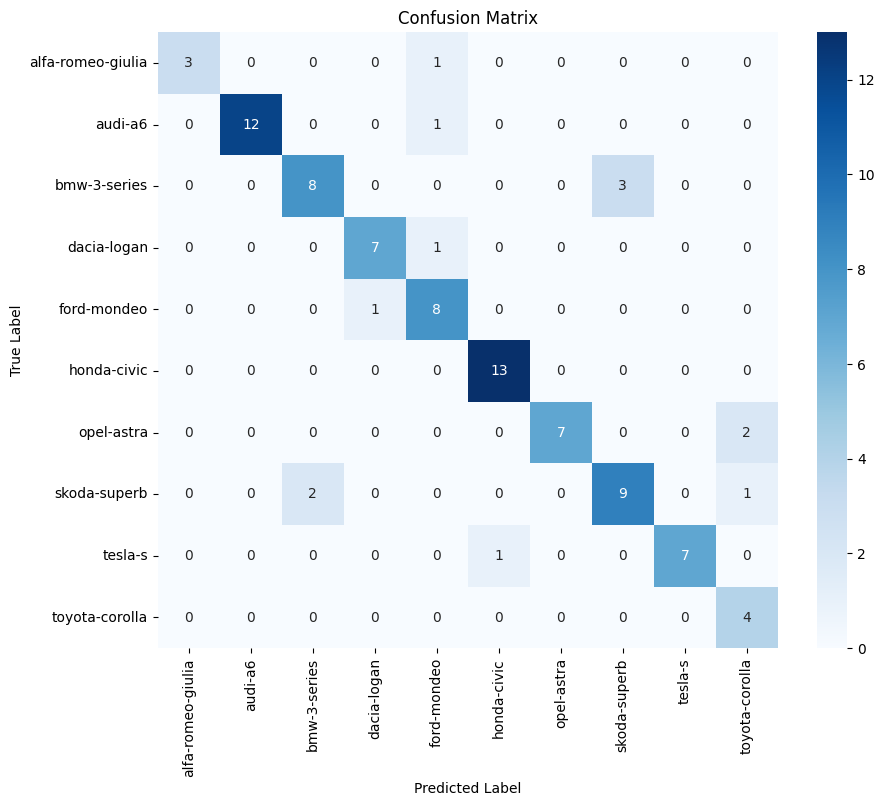

In [9]:
# Confusion matrix

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    xticklabels=class_names,
    yticklabels=class_names,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [10]:
# Classification report

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

balanced_acc = balanced_accuracy_score(y_true, y_pred)
print(f"\nBalanced Accuracy: {balanced_acc:.4f}")


Classification Report:

                   precision    recall  f1-score   support

alfa-romeo-giulia       1.00      0.75      0.86         4
          audi-a6       1.00      0.92      0.96        13
     bmw-3-series       0.80      0.73      0.76        11
      dacia-logan       0.88      0.88      0.88         8
      ford-mondeo       0.73      0.89      0.80         9
      honda-civic       0.93      1.00      0.96        13
       opel-astra       1.00      0.78      0.88         9
     skoda-superb       0.75      0.75      0.75        12
          tesla-s       1.00      0.88      0.93         8
   toyota-corolla       0.57      1.00      0.73         4

         accuracy                           0.86        91
        macro avg       0.87      0.86      0.85        91
     weighted avg       0.88      0.86      0.86        91


Balanced Accuracy: 0.8567
